Q1-using sklearn, extract test set

In [1]:
import numpy as np 
np.set_printoptions(precision=3)
import pandas as pd
pd.set_option('display.precision',3)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
real = pd.read_csv('real.csv', index_col=0) #1열부터 시작
real.columns = ['date','house_age','dist_mrt','no_cvs','lat','long','price']

real = real.drop(['date','lat','long'], axis=1)
real2=real.copy()

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(real, test_size=0.2, random_state=413)
print(train.shape)
print(test.shape)

(331, 4)
(83, 4)


In [4]:
X_train=train.iloc[:,range(0,3)]
y_train=train.iloc[:,[3]]
X_test=test.iloc[:,range(0,3)]
y_test=test.iloc[:,[3]]

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True) #inplace 는 original data를 가지고 변경 /  drop=True는 기존의 index열을 삭제

Feature scaling

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

def Scl_train(sclr, df):
    colnames = df.columns
    df = sclr.transform(df)
    df = pd.DataFrame(df)
    df.set_axis(colnames, axis=1, inplace=True)
    return df

In [6]:
X_train_sc = Scl_train(scaler, X_train)
X_test_sc = Scl_train(scaler, X_test)

Q2-Polynomial basis Feature Extraction

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px

In [8]:
def Poly_Reg(X_train, Y_train, X_test, Y_test, m, fig=False):
    # Feature Extraction
    poly = PolynomialFeatures(degree=m)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # LR Fitting
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X_train_poly, Y_train)
    Y_train_pred = lin.predict(X_train_poly)
    Y_test_pred = lin.predict(X_test_poly)

    # Compue MSE
    train_MSE = np.sqrt(np.linalg.norm(Y_train - Y_train_pred)**2/Y_train.shape[0])
    test_MSE = np.sqrt(np.linalg.norm(Y_test - Y_test_pred)**2/Y_test.shape[0])

    # Visualize
    if fig is True:
        fig = px.scatter_3d(x=X_train.dist_mrt, y=X_train.house_age, z=Y_train_pred)
        fig.update_traces(marker=dict(size=4,
                                  line=dict(width=0.1,
                                            color='DarkSlateGrey')))
        fig.show()
    
    # Residual
    Resid = Y_train - Y_train_pred
    
    return {'coef':lin.coef_, 'train_MSE':train_MSE, 'test_MSE':test_MSE, 'Resid':Resid}

In [9]:
PRmodel = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, 2, fig=False)
PRmodel

{'coef': array([[ 33.737,  -3.781, -13.348,   0.658,   2.113,   1.34 ,   0.488,
           1.292,  -4.031,  -1.387]]),
 'train_MSE': 8.597916169212406,
 'test_MSE': 7.553375987834902,
 'Resid':       price
 0    12.103
 1    -1.675
 2     0.193
 3    -0.727
 4    -4.761
 ..      ...
 326  -0.682
 327   0.089
 328 -12.416
 329   8.757
 330   5.121
 
 [331 rows x 1 columns]}

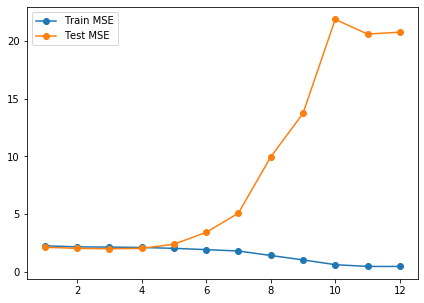

In [10]:
output = pd.DataFrame(columns=['d','Train MSE','Test MSE'])
for i in np.arange(12):
    m = i+1
    Reg = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, m, fig=False)
    output.loc[i] = [m, Reg['train_MSE'], Reg['test_MSE']]


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(output['d'], np.log(output['Train MSE']), 'o-', label='Train MSE')
ax.plot(output['d'], np.log(output['Test MSE']), 'o-', label='Test MSE')

ax.legend()

Q3-Ridge/Lasso Reg

Ridge

In [11]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
alphas=np.logspace(-6, 6, 500)
#alpha 낮게 = 규제 약하게 = overfitting 방향
#alpha 높게 = 규제 강하게 = underfitting 방향

poly = PolynomialFeatures(degree=2)
Phi_train = poly.fit_transform(X_train_sc)
Phi_test = poly.fit_transform(X_test_sc)
print(Phi_train.shape)
print(Phi_test.shape)

(331, 10)
(83, 10)


In [12]:
def Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Ridge?##
    #1. Call Ridge function as an object
    reg = Ridge()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))

    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [[  0.     -3.654 -10.07    2.154   2.178   1.438   0.394   1.113  -1.79
   -0.743]]


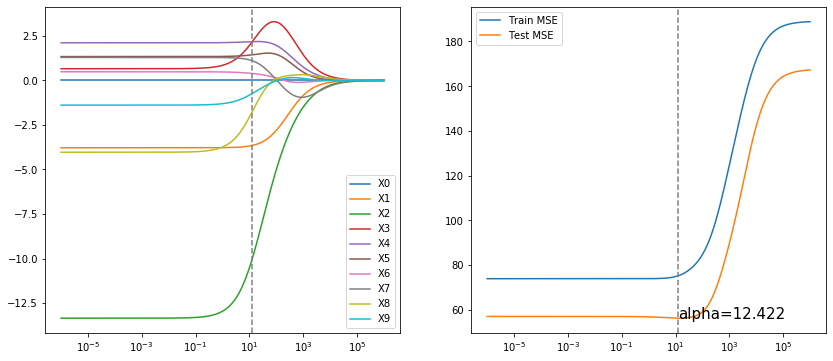

In [13]:
Ridge_output = Ridge_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

Lasso

In [14]:
from sklearn.linear_model import Lasso
alphas=np.logspace(-6, 6, 500)

In [15]:
def Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Lasso?##
    #1. Call Lasso function as an object
    reg = Lasso()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
    
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [  0.     -3.492 -10.137   2.075   1.776   0.687   0.      1.522  -0.574
  -0.   ]


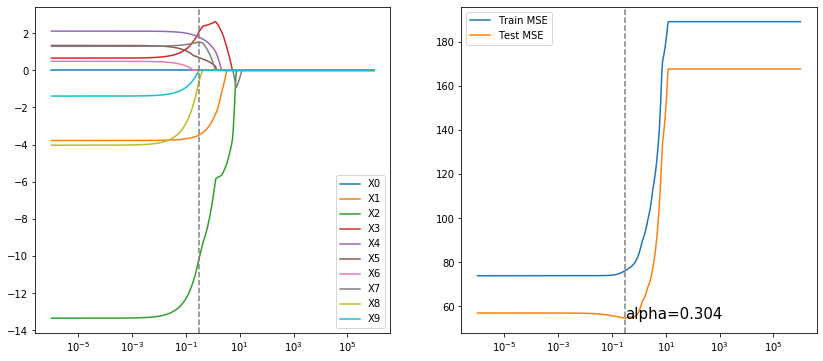

In [16]:
Lasso_output = Lasso_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

Ridge가 완만하게 계수를 조진다면, Lasso는 화끈하게 쳐내버리는 것을 볼 수 있다

Q4: k-fold CV for  𝜆

In [17]:
import numpy as np
from sklearn.model_selection import KFold

kcv = KFold(n_splits=5, shuffle=True)

kcvMSE_Ridge = np.zeros((kcv.get_n_splits(), alphas.size))
kcvMSE_Lasso = np.zeros((kcv.get_n_splits(), alphas.size))

i = 0
for train_index, test_index in kcv.split(Phi_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    CV_Phi_train, CV_Phi_test = Phi_train[train_index,:], Phi_train[test_index,:]
    CV_y_train, CV_y_test = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    
    Ridge_output = Ridge_Reg(CV_Phi_train, CV_y_train, CV_Phi_test, CV_y_test, alphas, fig=False)
    kcvMSE_Ridge[i, :] = Ridge_output['test_MSE']
    
    Lasso_output = Lasso_Reg(CV_Phi_train, CV_y_train, CV_Phi_test, CV_y_test, alphas, fig=False)
    kcvMSE_Lasso[i, :] = Lasso_output['test_MSE']
    i += 1

TRAIN: [  0   1   2   3   4   5   6   9  10  13  14  16  17  20  21  22  24  25
  27  28  29  30  31  32  33  35  36  37  38  39  40  41  42  43  44  45
  46  48  49  51  52  53  54  55  56  57  58  59  60  62  63  65  67  68
  70  71  72  75  76  77  78  79  80  83  84  85  86  87  88  89  91  92
  93  95  96  98  99 100 101 103 104 105 106 107 108 109 111 114 115 116
 117 119 120 122 123 124 125 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 144 145 146 147 148 150 151 152 153 154 155 156 159
 161 162 163 164 165 166 167 169 170 171 173 175 176 177 179 180 181 182
 183 184 185 186 188 189 190 191 192 193 194 195 196 197 198 200 201 202
 204 205 207 209 210 211 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 231 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 248 249 250 252 254 255 256 257 258 260 261 262 263 264 266 270
 271 272 273 274 276 277 278 279 280 281 283 284 285 287 288 289 290 291
 293 294 295 296 297 299 300 301 302 303 304

Weight: [[  0.     -3.825 -14.296   0.27    1.406   1.481   0.229   1.639  -3.741
   -1.596]]


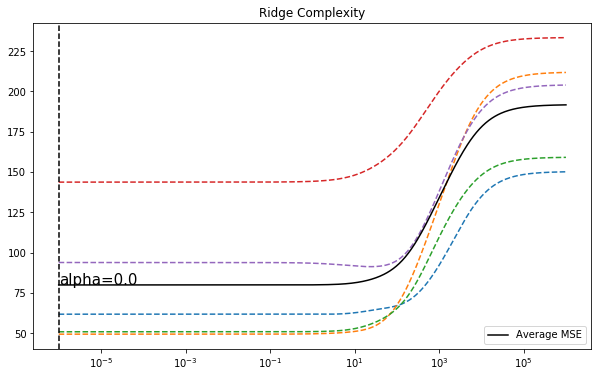

In [18]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE1 = np.apply_along_axis(np.mean, 1, kcvMSE_Ridge.T)
ax.plot(alphas, kcvMSE_Ridge.T, linestyle='--')
ax.plot(alphas, meanMSE1, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE1)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE1)],3)
ax.text(alphas[np.argmin(meanMSE1)], np.amin(meanMSE1), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Ridge Complexity')
ax.legend()

coefs = Ridge_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE1)])

Weight: [  0.     -3.825 -14.296   0.27    1.406   1.481   0.229   1.639  -3.741
  -1.596]


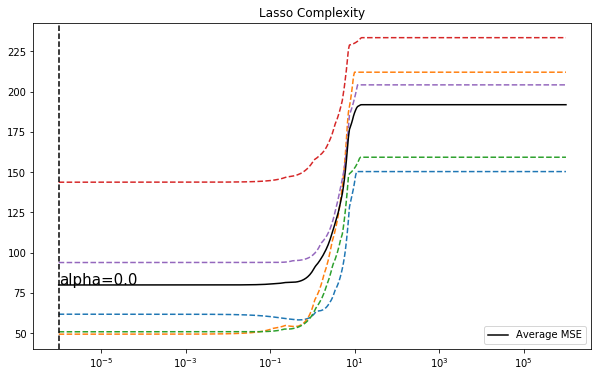

In [19]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE2 = np.apply_along_axis(np.mean, 1, kcvMSE_Lasso.T)
ax.plot(alphas, kcvMSE_Lasso.T, linestyle='--')
ax.plot(alphas, meanMSE2, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE2)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE2)],3)
ax.text(alphas[np.argmin(meanMSE2)], np.amin(meanMSE2), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Lasso Complexity')
ax.legend()

coefs = Lasso_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE2)])

Q5:최종적으로 test MSE 보고 후, 어떤 feature가 선택되었으며, 왜 그랬는지 설명해보기

In [20]:
rdg=Ridge(alpha=alphas[np.argmin(meanMSE1)])
rdg.fit(Phi_train, y_train)
rdg.coef_

array([[  0.   ,  -3.781, -13.348,   0.658,   2.113,   1.34 ,   0.488,
          1.292,  -4.031,  -1.387]])

In [21]:
lso=Lasso(alpha=alphas[np.argmin(meanMSE2)])
lso.fit(Phi_train, y_train)
lso.coef_

array([  0.   ,  -3.781, -13.348,   0.658,   2.113,   1.34 ,   0.488,
         1.292,  -4.031,  -1.387])